# Calculate Statistics for Multiple Models per Year

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from gensim.models import Word2Vec, KeyedVectors
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import plotnine as p9
from plydata import define, select, group_by, do, ungroup, query, arrange
import tqdm
from umap.parametric_umap import ParametricUMAP, load_ParametricUMAP

from biovectors_modules.word2vec_analysis_helper import align_word2vec_models

# Load Word2Vec model

In [2]:
word_models = list(Path("output/models").rglob("*model"))
word_models = sorted(word_models, key=lambda x: x.stem)
word_model_filter = list(filter(lambda x: "2000" in x.stem, word_models))

In [3]:
words_to_visualize = []
most_frequent_tokens = []

In [4]:
for model_file in tqdm.tqdm(word_model_filter):
    word_model = Word2Vec.load(str(model_file))
    word_model.init_sims()
    most_frequent_tokens.append(
        {word: word_model.wv[word] for word in word_model.wv.index2word[:100]}
    )
    words_to_visualize.append(np.array(word_model.wv.vectors))

words_to_visualize = np.vstack(words_to_visualize)

100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


# Train the UMAP model on Unaligned Vectors

In [5]:
file_name = "output/umap_models/2000_no_alignment_replace"
tokens = list(most_frequent_tokens[0].keys())
words_subset = np.vstack(
    list(map(lambda x: np.vstack(list(x.values())), most_frequent_tokens))
)

In [6]:
if not Path(file_name).exists():
    model = ParametricUMAP(
        verbose=False,
        metric="cosine",
        random_state=100,
        low_memory=True,
        n_neighbors=25,
        min_dist=0.0,
    )
    model.fit(words_to_visualize)
    embedding = model.transform(words_subset)
    model.save(file_name)
else:
    model = load_ParametricUMAP(file_name)
    embedding = model.transform(words_subset)

Pickle of ParametricUMAP model loaded from umap_models/2000_no_alignment_replace/model.pkl
Keras encoder model loaded from umap_models/2000_no_alignment_replace/encoder
Keras full model loaded from umap_models/2000_no_alignment_replace/parametric_model


In [7]:
mapped_df = (
    pd.DataFrame(embedding, columns=["umap1", "umap2"])
    >> define(token=tokens * 10)
    >> define(
        model_iter=sorted(list(range(10)) * len(tokens))
    )  # copy each model iter for each token num
)
mapped_df.model_iter = pd.Categorical(mapped_df.model_iter)
mapped_df.head()

,umap1,umap2,token,model_iter
0,-34.329773,-35.093857,,0
1,-35.221748,-34.906582,the,0
2,-34.891552,-34.845005,of,0
3,-35.445126,-34.997684,",",0
4,-35.346123,-34.903339,.,0


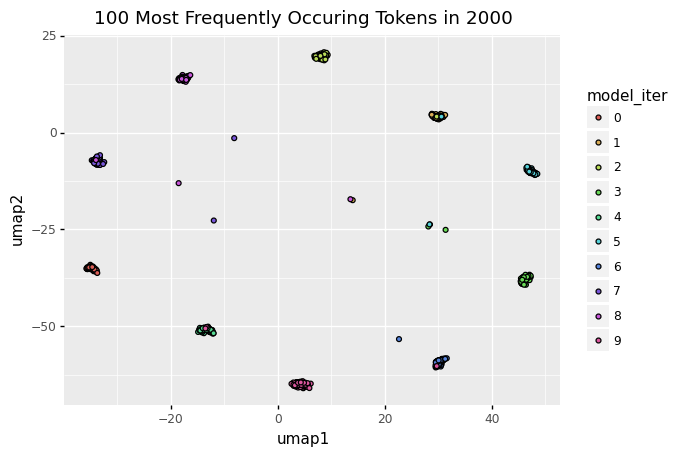

In [8]:
g = (
    p9.ggplot(mapped_df, p9.aes(x="umap1", y="umap2", fill="model_iter"))
    + p9.geom_point()
    + p9.labs(title="100 Most Frequently Occuring Tokens in 2000")
)
print(g)

# Train UMAP Model on Aligned Vectors

In [9]:
base_model = Word2Vec.load(str(word_models[-1]))
words_to_visualize = []
most_frequent_tokens = []

In [10]:
for model_file in tqdm.tqdm(word_model_filter):
    word_model = Word2Vec.load(str(model_file))
    aligned_model = align_word2vec_models(base_model.wv, word_model.wv)
    most_frequent_tokens.append(
        {word: aligned_model.wv[word] for word in aligned_model.wv.index2word[:100]}
    )
    words_to_visualize.append(np.array(aligned_model.wv.vectors))

words_to_visualize = np.vstack(words_to_visualize)

  0%|          | 0/10 [00:00<?, ?it/s]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
 10%|█         | 1/10 [00:01<00:09,  1.10s/it]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
 20%|██        | 2/10 [00:02<00:09,  1.16s/it]/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/ipykernel_launcher.py:6: Depre

In [11]:
file_name = "output/umap_models/2000_with_alignment_replace"
tokens = list(most_frequent_tokens[0].keys())
words_subset = np.vstack(
    list(map(lambda x: np.vstack(list(x.values())), most_frequent_tokens))
)

In [12]:
if not Path(file_name).exists():
    model = ParametricUMAP(
        verbose=False,
        metric="cosine",
        random_state=100,
        low_memory=True,
        n_neighbors=25,
        min_dist=0.0,
    )
    model.fit(words_to_visualize)
    embedding = model.transform(words_subset)
    model.save(file_name)
else:
    model = load_ParametricUMAP(file_name)
    embedding = model.transform(words_subset)

Pickle of ParametricUMAP model loaded from umap_models/2000_with_alignment_replace/model.pkl
Keras encoder model loaded from umap_models/2000_with_alignment_replace/encoder
Keras full model loaded from umap_models/2000_with_alignment_replace/parametric_model


In [13]:
mapped_df = (
    pd.DataFrame(embedding, columns=["umap1", "umap2"])
    >> define(token=tokens * 10)
    >> define(
        model_iter=sorted(list(range(10)) * len(tokens))
    )  # copy each model iter for each token num
)
mapped_df.model_iter = pd.Categorical(mapped_df.model_iter)
mapped_df.head()

,umap1,umap2,token,model_iter
0,-4.409549,-2.479130,,0
1,-1.111571,-3.589401,the,0
2,0.872305,-4.832456,",",0
3,-1.412238,-1.447580,.,0
4,-1.626051,-7.578313,of,0


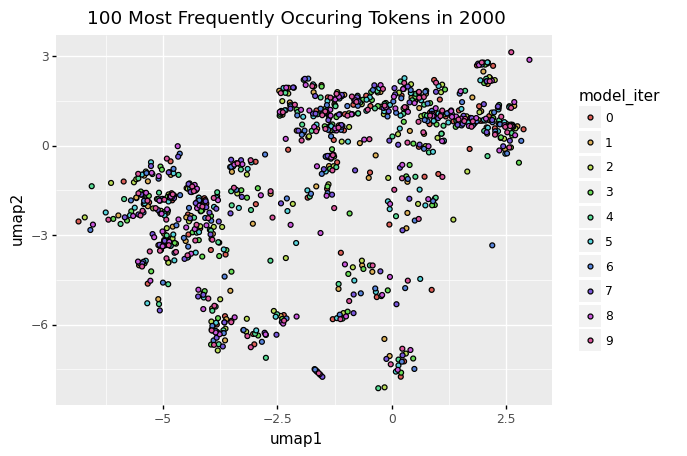

In [14]:
g = (
    p9.ggplot(mapped_df, p9.aes(x="umap1", y="umap2", fill="model_iter"))
    + p9.geom_point()
    + p9.labs(title="100 Most Frequently Occuring Tokens in 2000")
)
print(g)

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/scales/scale_alpha.py:70: PlotnineWarning: Using alpha for a discrete variable is not advised.


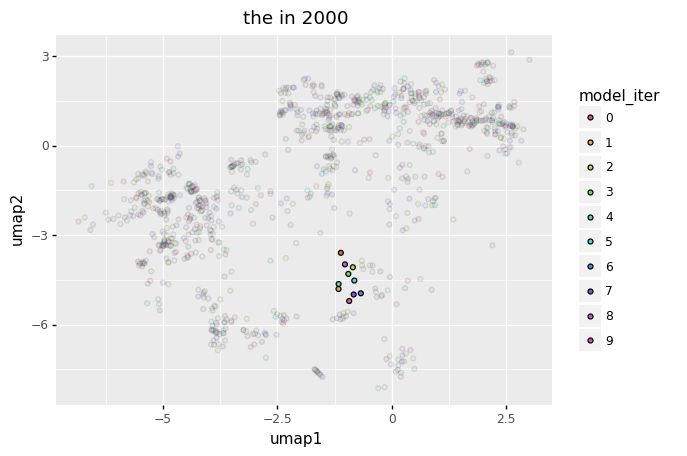

In [15]:
g = (
    p9.ggplot(
        mapped_df >> define(opacity=lambda x: x.token == "the"),
        p9.aes(x="umap1", y="umap2", fill="model_iter", alpha="opacity"),
    )
    + p9.geom_point()
    + p9.labs(title="the in 2000")
    + p9.guides(alpha=False)
)
print(g)

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/scales/scale_alpha.py:70: PlotnineWarning: Using alpha for a discrete variable is not advised.


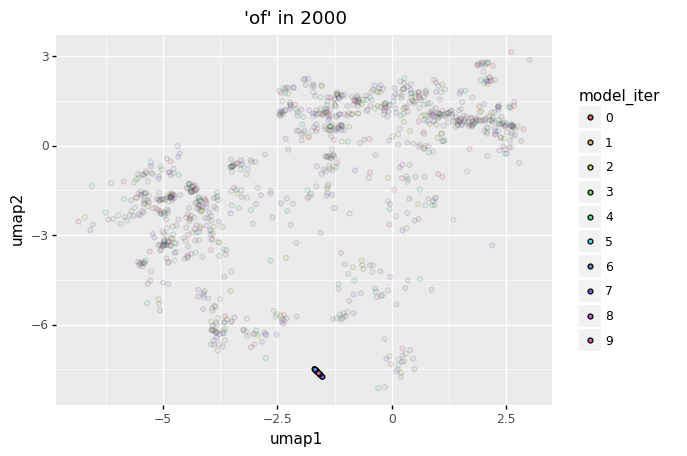

In [16]:
g = (
    p9.ggplot(
        mapped_df >> define(opacity=lambda x: x.token == "of"),
        p9.aes(x="umap1", y="umap2", fill="model_iter", alpha="opacity"),
    )
    + p9.geom_point()
    + p9.labs(title="'of' in 2000")
    + p9.guides(alpha=False)
)
print(g)